In [1]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
import spacy
import torch
import torch.nn.functional as F
import numpy as np
import pandas as pd
from diffusers.utils import make_image_grid
from transformers import (
    SamModel,
    SamProcessor,
    Blip2Processor,
    Blip2ForConditionalGeneration,
    AutoProcessor,
    LlavaForConditionalGeneration,
)
from PIL import Image

from src.eunms import Model_Type, Scheduler_Type
from src.utils.enums_utils import get_pipes
from src.config import RunConfig
from main import run as invert

from attention_maps_utils_by_timesteps import (
    get_attn_maps,
    cross_attn_init,
    register_cross_attention_hook,
    set_layer_with_name_and_path,
    # preprocess,
    # visualize_and_save_attn_map,
)

/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarnin

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_type = Model_Type.SDXL_Turbo
scheduler_type = Scheduler_Type.EULER
pipe_inversion, pipe_inference = get_pipes(model_type, scheduler_type, device=device)

Keyword arguments {'safety_checker': None} are not expected by StableDiffusionXLImg2ImgPipeline and will be ignored.
Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:00,  9.26it/s]/cortex/users/yairshp/miniconda3/envs/renoise_inversion/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
Loading pipeline components...: 100%|██████████| 7/7 [00:01<00:00,  6.14it/s]


In [4]:
config = RunConfig(
    model_type=model_type,
    scheduler_type=scheduler_type,
    noise_regularization_lambda_kl=0.055,
    noise_regularization_lambda_ac=10,
    num_inversion_steps=4,
    num_inference_steps=4,
)

In [5]:
data_path = (
    "/home/lab/yairshp/projects/insert_object/benchmark/object_placement_images.csv"
)
data = pd.read_csv(data_path, dtype={"bg_img_id": str, "ref_img_id": str})
open_images_path = "/cortex/data/images/OpenImagesV6/images"
cocoee_path = "/cortex/data/images/COCOEE/test_bench/Ref_3500"

# open_images dataset is used for bg_images. add a column of the path to the image (the path is the <open_images_path>/<image_id>.jpg)
data["bg_img_path"] = data["bg_img_id"].apply(lambda x: f"{open_images_path}/{x}.jpg")

# cocoee dataset is used for ref_images. add a column of the path to the image (the path is the <cocoee_path>/<image_id>_ref.png)
data["ref_img_path"] = data["ref_img_id"].apply(lambda x: f"{cocoee_path}/{x}_ref.png")

In [6]:
my_bg_images = [
    "/home/lab/yairshp/projects/insert_object/benchmark/bed.jpeg",
    "/home/lab/yairshp/projects/insert_object/benchmark/desk.jpeg",
    "/home/lab/yairshp/projects/insert_object/benchmark/cabinet.jpeg",
    "/home/lab/yairshp/projects/insert_object/benchmark/face.jpg",
]

my_object_images = [
    "/home/lab/yairshp/projects/insert_object/benchmark/objects/pillow/pillow.jpeg",
    "/home/lab/yairshp/projects/insert_object/benchmark/objects/plant/plant.jpg",
    "/home/lab/yairshp/projects/insert_object/benchmark/objects/vase/vase.jpeg",
    "/home/lab/yairshp/projects/insert_object/benchmark/objects/hat/hat.png",
]

In [7]:
bg_images = list(data["bg_img_path"])
bg_images.extend(my_bg_images)
ref_images = list(data["ref_img_path"])
ref_images.extend(my_object_images)

In [8]:
def preprocess_image(image_path):
    image = Image.open(image_path)
    return image.convert("RGB").resize((512, 512))


bg_images = [preprocess_image(image) for image in bg_images]
ref_images = [preprocess_image(image) for image in ref_images]

In [9]:
def invert_images(images, prompts):
    inv_latents = []
    noises = []
    for image, prompt in zip(images, prompts):
        _, inv_latent, noise, _ = invert(
            image,
            prompt,
            config,
            pipe_inversion=pipe_inversion,
            pipe_inference=pipe_inference,
            do_reconstruction=False,
        )
        inv_latents.append(inv_latent)
        noises.append(noise)
    return inv_latents, noises

In [10]:
inversion_prompts = ["an image" for _ in range(len(bg_images))]

In [11]:
inv_latents, noises = invert_images(bg_images, inversion_prompts)

Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.12s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.07s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.08s/it]


Inverting...


100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Inverting...


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Inverting...


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Inverting...


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


Inverting...


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Inverting...


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Inverting...


100%|██████████| 4/4 [00:03<00:00,  1.04it/s]


Inverting...


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Inverting...


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Inverting...


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Inverting...


100%|██████████| 4/4 [00:03<00:00,  1.03it/s]


Inverting...


100%|██████████| 4/4 [00:03<00:00,  1.01it/s]


Inverting...


100%|██████████| 4/4 [00:03<00:00,  1.02it/s]


In [12]:
cross_attn_init()
pipe_inference.unet = set_layer_with_name_and_path(pipe_inference.unet)
pipe_inference.unet = register_cross_attention_hook(pipe_inference.unet)

In [13]:
def prompt2tokens(tokenizer, prompt):
    text_inputs = tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="pt",
    )
    text_input_ids = text_inputs.input_ids
    tokens = []
    for text_input_id in text_input_ids[0]:
        token = tokenizer.decoder[text_input_id.item()]
        tokens.append(token)
    return tokens


def visualize_and_save_attn_map(attn_map, tokenizer, prompt):
    # match with tokens
    tokens = prompt2tokens(tokenizer, prompt)
    bos_token = tokenizer.bos_token
    eos_token = tokenizer.eos_token
    pad_token = tokenizer.pad_token
    save_path = "attn_maps"
    if not os.path.exists(save_path):
        os.mkdir(save_path)

    # to_pil = transforms.ToPILImage()
    for i, (token, token_attn_map) in enumerate(zip(tokens, attn_map)):
        if token != eos_token:
            continue
        token = token.replace("</w>", "")
        token = f"{i}_<{token}>.jpg"

        # low quality
        # to_pil(255 * token_attn_map).save(os.path.join(save_path, token))
        # to_pil(255 * (token_attn_map - torch.min(token_attn_map)) / (torch.max(token_attn_map) - torch.min(token_attn_map))).save(os.path.join(save_path, token))

        token_attn_map = token_attn_map.cpu().numpy()
        normalized_token_attn_map = (
            (token_attn_map - np.min(token_attn_map))
            / (np.max(token_attn_map) - np.min(token_attn_map))
            * 255
        )
        normalized_token_attn_map = normalized_token_attn_map.astype(np.uint8)
        image = Image.fromarray(normalized_token_attn_map)
        # image.save(os.path.join(save_path, token))
        return image

In [17]:
def process_attn_map(timestep_attn_maps, tokenizer, prompt):
    # max_height, max_width = 0, 0
    preprocessed_attn_maps = {}
    for k, v in timestep_attn_maps.items():
        v = torch.mean(v.cpu(), axis=0).squeeze(0)
        if v.shape[-1] != 16:
            continue
        # if len(v.shape) == 3:
        #     _, h, w = v.shape
        # else:
        #     h, w = v.shape
        # max_height = max(h, max_height)
        # max_width = max(w, max_width)
        # v = F.interpolate(
        #     v.to(dtype=torch.float32).unsqueeze(0),
        #     size=(max_height, max_width),
        #     mode="bilinear",
        #     align_corners=False,
        # ).squeeze(
        #     0
        # )  # (77,64,64)
        preprocessed_attn_maps[k] = v
        # attn_maps[k] = v

    attn_map = torch.stack(list(preprocessed_attn_maps.values()), axis=0)
    attn_map = torch.mean(attn_map, axis=0)

    tokens = prompt2tokens(tokenizer, prompt)
    eos_token = tokenizer.eos_token
    for token, token_attn_map in zip(tokens, attn_map):
        if token != eos_token:
            continue
        return token_attn_map

    # return attn_map


def get_attn_map(edit_prompt, tokenizer):
    attn_maps = get_attn_maps()
    attn_map = process_attn_map(attn_maps[-1], tokenizer, edit_prompt)
    return attn_map
    # attn_maps_images = []
    # for attn_map in attn_maps:
    #     attn_map = preprocess(attn_map, 512, 512)
    #     attn_map_img = visualize_and_save_attn_map(
    #         attn_map, pipe_inference.tokenizer, edit_prompt
    #     )
    #     attn_maps_images.append(attn_map_img)
    # return attn_maps_images


def reset_attn_maps():
    attn_maps = get_attn_maps()
    attn_maps.clear()


def get_edit_images_and_attn_maps(inv_latents, noises, inversion_prompts, edit_prompts):
    edit_images = []
    per_timestep_attn_maps = []
    for inv_latent, noise, inversion_prompt, edit_prompt in zip(
        inv_latents, noises, inversion_prompts, edit_prompts
    ):
        pipe_inference.scheduler.set_noise_list(noise)
        pipe_inference.cfg = config
        edit_image = pipe_inference(
            prompt=edit_prompt,
            num_inference_steps=config.num_inference_steps,
            negative_prompt=inversion_prompt,
            image=inv_latent,
            strength=config.inversion_max_step,
            denoising_start=1.0 - config.inversion_max_step,
            guidance_scale=config.guidance_scale,
        ).images[0]
        edit_images.append(edit_image)
        per_timestep_attn_maps.append(
            get_attn_map(edit_prompt, pipe_inference.tokenizer)
        )
        reset_attn_maps()

    return edit_images, per_timestep_attn_maps

In [15]:
edit_prompts = inversion_prompts

In [18]:
edit_images, per_timestep_attn_maps = get_edit_images_and_attn_maps(
    inv_latents, noises, inversion_prompts, edit_prompts
)

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [00:00<00:00, 11.64it/s]


In [ ]:
image_grid_arr = []
for bg_image, edit_image, sample_attn_maps in zip(
    bg_images, edit_images, per_timestep_attn_maps
):
    image_grid_arr.append(bg_image)
    # image_grid_arr.append(edit_image)
    # for attn_map in sample_attn_maps:
    #     image_grid_arr.append(attn_map)
    image_grid_arr.append(sample_attn_maps[-1])

In [23]:
# attn_maps_images = [
#     Image.fromarray((attn_map.cpu().numpy() * 255))
#     for attn_map in per_timestep_attn_maps
# ]

In [ ]:
# make_image_grid(image_grid_arr, len(bg_images), 2)
make_image_grid(attn_maps_images, len(attn_maps_images), 1)
# make_image_grid(image_grid_arr, len(bg_images), 2 + len(per_timestep_attn_maps[0]))

In [ ]:
# for i, attn_maps in enumerate(per_timestep_attn_maps):
#     attn_maps[-1].save(f"attn_maps/{i}.jpg")

In [33]:
a = per_timestep_attn_maps[2].cpu().numpy()

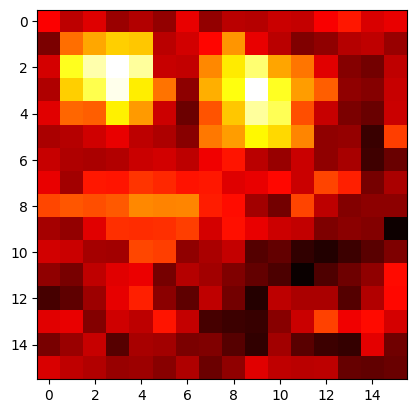

In [34]:
import matplotlib.pyplot as plt

plt.imshow(a, cmap="hot", interpolation="nearest")
plt.show()

In [35]:
a.min(), a.max()

(0.072, 0.1198)